# TensorFlow: Image Classify Binary

*Brain Tumor Detection via Binary Classification of Magnetic Resonance Imaging (MRI) Scans*

<img src="../../../_static/images/banner/brains.png" class="banner-photo"/>

## Example Data

Reference [Example Datasets](../../datasets.html) for more information.

This dataset is comprised of:

* *Features* = folder of magnetic resonance imaging (MRI) of brain samples.
* *Labels* = tabular data denoting the presence of a tumor.

In [2]:
from aiqc import datum
from aiqc.orm import Dataset

In [3]:
df = datum.to_pandas('brain_tumor.csv')
dataset_label = Dataset.Tabular.from_pandas(df)

In [4]:
dataset_label.to_pandas().head(3)

,status,size,count,symmetry,url
0,0,0,0,None,https://raw.githubusercontent.com/aiqc/aiqc/ma...
1,0,0,0,None,https://raw.githubusercontent.com/aiqc/aiqc/ma...
2,0,0,0,None,https://raw.githubusercontent.com/aiqc/aiqc/ma...


In [5]:
urls = datum.get_remote_urls(manifest_name='brain_tumor.csv')
dataset_img = Dataset.Image.from_urls_pillow(urls)

🖼️ Ingesting Images 🖼️: 100%|████████████████████████| 80/80 [00:14<00:00,  5.49it/s]


In [6]:
images_pillow = dataset_img.to_pillow(samples=[6,47])

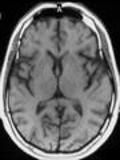

In [7]:
images_pillow[0]

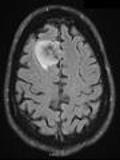

In [8]:
images_pillow[1]

---

## Pipeline

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [10]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import FunctionTransformer
from aiqc.utils.encoding import div255, mult255

In [11]:
pipeline = Pipeline(
    Input(
        dataset           = dataset_img
        , encoders        = Input.Encoder(FunctionTransformer(div255, inverse_func=mult255))
        , reshape_indices = (0,2,3)#reshape for Conv1D grayscale.
    ),
        
    Target(
        dataset  = dataset_label
        , column = 'status'
    ),

    Stratifier(
        size_test         = 0.14
        , size_validation = 0.22
    )
)

---

## Modeling

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [12]:
from aiqc.mlops import Experiment, Architecture, Trainer
import tensorflow as tf
from tensorflow.keras import layers as l
from aiqc.utils.tensorflow import TrainingCallback

In [13]:
def fn_build(features_shape, label_shape, **hp):
    m = tf.keras.models.Sequential()
    
    # Convolutional block.
    for i in range(hp['blocks']):
        # Starts big and gets smaller
        multiplier = hp['blocks'] - i
        
        if (i == 0):
            m.add(l.Conv1D(
                hp['filters']*multiplier
                , input_shape=features_shape # <-- the only difference
                , kernel_size=hp['kernel_size']
                , padding='same'
                , kernel_initializer=hp['cnn_init']
            ))
        elif (i > 0):
            m.add(l.Conv1D(
                hp['filters']*multiplier
                , kernel_size=hp['kernel_size']
                , padding='same'
                , kernel_initializer=hp['cnn_init']
            ))
        
        m.add(l.Activation('relu'))
        m.add(l.MaxPool1D(pool_size=hp['pool_size']))
        m.add(l.Dropout(0.4))

    m.add(l.Flatten())
    
    # Dense block.
    for i in range(hp['dense_blocks']): 
        m.add(l.Dense(hp['dense_neurons']))
        m.add(l.BatchNormalization())
        m.add(l.Activation('relu'))
        m.add(l.Dropout(0.4))
    
    # Output layer.
    m.add(l.Dense(label_shape[0], activation='sigmoid'))
    return m

In [19]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):
    model.compile(
        optimizer = optimizer
        , loss    = loser
        , metrics = ['accuracy']
    )
    
    # Early stopping.
    metric_cutoffs = [
        dict(metric='val_accuracy', cutoff=0.90, above_or_below='above')
        , dict(metric='accuracy',     cutoff=0.90, above_or_below='above')
        , dict(metric='val_loss',     cutoff=1.00, above_or_below='below')
        , dict(metric='loss',         cutoff=1.00, above_or_below='below')
    ]
    cutoffs   = TrainingCallback.MetricCutoff(metric_cutoffs)
    callbacks = [tf.keras.callbacks.History(), cutoffs]
    
    # Training runs.
    model.fit(
        train_features, train_label
        , validation_data = (eval_features, eval_label)
        , verbose         = 0
        , batch_size      = hp['batch_size']
        , epochs          = hp['epoch_count']
        , callbacks       = callbacks
    )
    return model

In [20]:
hyperparameters = dict(
    blocks          = [4]
    , filters       = [24]
    , pool_size     = [2]
    , kernel_size   = [3]
    , batch_size    = [8] #8 did best. tried 5 and 6 again, no.
    , cnn_init      = ['normal'] #default is glorot
    , dense_blocks  = [1]
    , dense_neurons = [32] #64 did well.
    , epoch_count   = [100]
)

In [23]:
experiment = Experiment(
    Architecture(
        library           = "keras"
        , analysis_type   = "classification_binary"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(
        pipeline       = pipeline
        , repeat_count = 2
    )
)

In [24]:
experiment.run_jobs()

🔮 Training Models 🔮: 100%|██████████████████████████████████████████| 2/2 [00:20<00:00, 10.47s/it]


---

## Visualization & Interpretation

For more information on visualization of performance metrics, reference the [Dashboard](../../dashboard.html) documentation.